In [1]:
import os
import math
import time
import random
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
# custom imports
import sys

sys.path.append(os.path.abspath(os.path.join('..', '..', 'utils')))

In [3]:
colors = [
    'blue', 'green', 'red', 'cyan', 'magenta',
    'yellow', 'black', 'orange', 'purple', 'brown',
    'pink', 'grey', 'maroon', 'gold', 'chocolate',
    'aqua', 'darkviolet', 'crimson', 'navy', 'darkgreen',
    'peru', 'tan', 'seagreen', 'darkslategrey', 'teal'
]

In [4]:
# constants
A = 3e-4
use_sin = True

## First let's try to detect the helical trajectory (for the x-y plane) in a single-particle file

In [5]:
# Get all the "Hits" data files
root_dir = os.path.join('..', '..', '..', 'data', 'pdg13-n1-1GeV-0.5eta')
hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
initial_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_initial.csv")])
final_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_final.csv")])
dfs = [pd.read_csv(os.path.join(root_dir, file)) for file in hit_files]
initial_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
               for file in initial_files]
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]

In [6]:
random.seed(8)
random_event = random.choice(range(0, len(dfs)))
print(f'Event chosen: {hit_files[random_event]}')
df = dfs[random_event]
initial_df = initial_dfs[random_event]
final_df = final_dfs[random_event]
df['weight'] = 1.0
df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
df['phi'] = np.arctan2(df['ty'], df['tx'])
df['track'] = df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
df.head()

Event chosen: event000000029-hits.csv


,particle_id,geometry_id,tx,ty,tz,tt,tpx,tpy,tpz,te,deltapx,deltapy,deltapz,deltae,index,weight,r,phi,track
0,4503599644147712,936748859932016764,16.683874,27.527729,7.455000,0.110797,0.510034,0.860154,0.231598,1.031892,0,0,0,0,0,1.0,32.188935,1.025922,"(32.18893472735766, 1.0259217315432712)"
1,4503599644147712,936748859932016778,17.186132,28.375339,7.683180,0.114188,0.509526,0.860455,0.231598,1.031892,0,0,0,0,1,1.0,33.174132,1.026217,"(33.174132070192734, 1.0262170908764476)"
2,4503599644147712,936748997370970502,34.540306,58.389202,15.712786,0.233525,0.491530,0.870861,0.231598,1.031892,0,0,0,0,2,1.0,67.840487,1.036611,"(67.84048693336703, 1.0366110277988427)"
3,4503599644147712,936749134809924310,57.039658,99.596489,26.586557,0.395131,0.466823,0.884351,0.231598,1.031892,0,0,0,0,3,1.0,114.773617,1.050687,"(114.7736170043114, 1.0506866179192182)"
4,4503599644147712,936749272248877138,81.947067,148.729919,39.344940,0.584747,0.437363,0.899285,0.231598,1.031892,0,0,0,0,4,1.0,169.811397,1.067202,"(169.81139727596994, 1.067201767998089)"


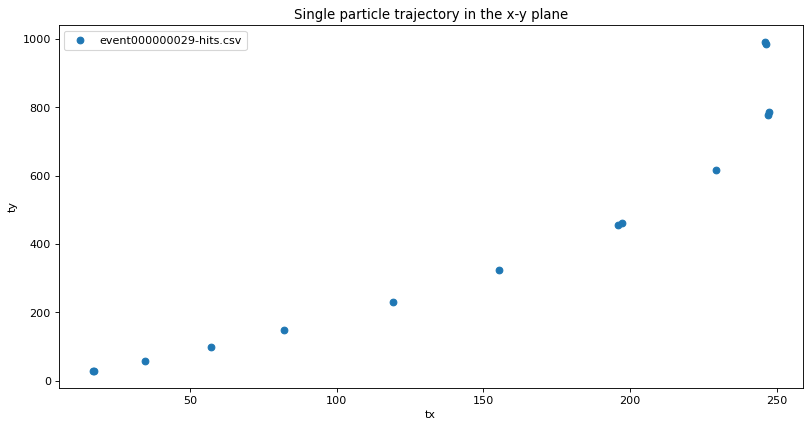

In [7]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=df['tx'], y=df['ty'], label=hit_files[random_event])

plt.xlabel('tx')
plt.ylabel('ty')
plt.legend(loc='best')
plt.title('Single particle trajectory in the x-y plane')
plt.show()

Using the formula

$$\frac{qA}{p_T} = \frac{\sin(\phi_0 - \phi_1)}{r_1}$$

By considering $q/p_T$ to be the $y$-unknown and $\phi_0$ to be the x-unknown, we get the following formula:

$$y = \frac{\sin(x - \phi)}{Ar}$$

where $r$ is the distance of an x-y point to the origin and $\phi$ is it's angle in polar coordinates.

Since in some cases we know that $\phi_0 \approx \phi_1$, we can substitute $\sin(x - \phi)$ with $x - \phi$, simplifying thus the given formula to a linear equation:

$$y = \frac{1}{Ar}x - \frac{\phi}{Ar}$$

Let's define here the bin size and the range of search in the x-axis ($\phi_0$).

In [8]:
all_tracks = list(df['track'])
bin_size = (0.001, 0.05)
width_limits = (0, np.pi)
x_range = np.arange(width_limits[0], width_limits[1], bin_size[0])

Let's plot the tracks in the Hough Space.

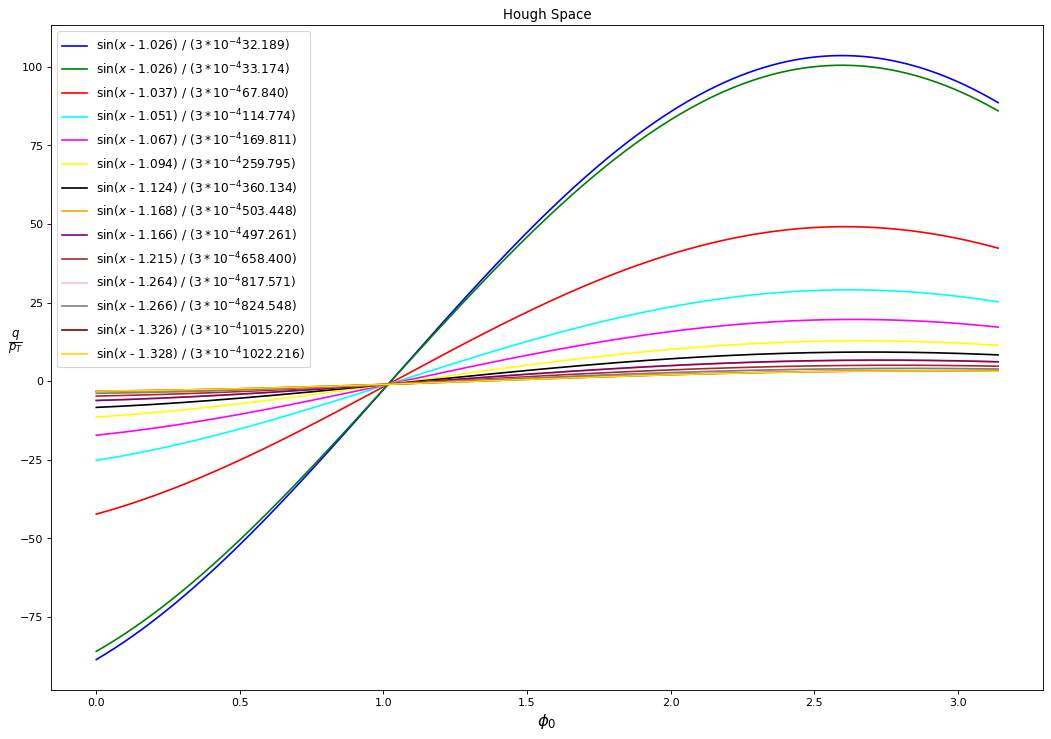

In [9]:
min_y, max_y = float('inf'), float('-inf')

plt.figure(figsize=(16, 11), dpi=80)
for idx, track in enumerate(all_tracks):
    r, phi = track
    if use_sin:
        label = '$\sin$($x$ - ' + '{:.3f}'.format(phi) + ') / ($3*10^{-4}$' + '{:.3f}'.format(r) + ')'
    else:
        label = '($x$ - ' + '{:.3f}'.format(phi) + ') / ($3*10^{-4}$' + '{:.3f}'.format(r) + ')'
    ys = np.sin(x_range - phi) / (A * r) if use_sin else (x_range - phi) / (A * r)
    min_y = min(np.min(ys), min_y)
    max_y = max(np.max(ys), max_y)
    plt.plot(x_range, ys, label=label, color=colors[idx % len(colors)])

plt.xlabel('$\phi_0$', fontsize=15)
h = plt.ylabel('$\\frac{q}{p_T}$', fontsize=15)
h.set_rotation(0)
plt.title('Hough Space')
plt.legend(loc='best', prop={'size': 11})
plt.show()

Let's run the pipeline and plot the results.

In [10]:
from notebook_utils import pipeline

height_limits = (min_y - 1, max_y + 1)
limits = (width_limits, height_limits)
selection_hyperparams = {'minimum-hits-per-bin': 10}

accumulator, est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, selection_hyperparams, use_sin=use_sin)
len(est_tracks_to_hits)

3

Before plotting, let's define a RoI (Region of Interest) for the y-axis $\frac{q}{p_T}$ values, in order to make the heatmap more readable. I chose the interval $[-5, 3]$, but any other interval can be hard coded as well below.

In [11]:
lower_qpt = -1.10
upper_qpt = -0.77
low_qpt_bin = int((lower_qpt - height_limits[0] - 1e-12) / bin_size[1])
high_qpt_bin = int((upper_qpt - height_limits[0] - 1e-12) / bin_size[1])

lower_phi = 1.01
upper_phi = 1.02
low_phi_bin = int((lower_phi - width_limits[0] - 1e-12) / bin_size[0])
high_phi_bin = int((upper_phi - width_limits[0] - 1e-12) / bin_size[0])

roi_accumulator = accumulator[low_phi_bin:high_phi_bin, low_qpt_bin:high_qpt_bin]
roi_accumulator.shape

(10, 6)

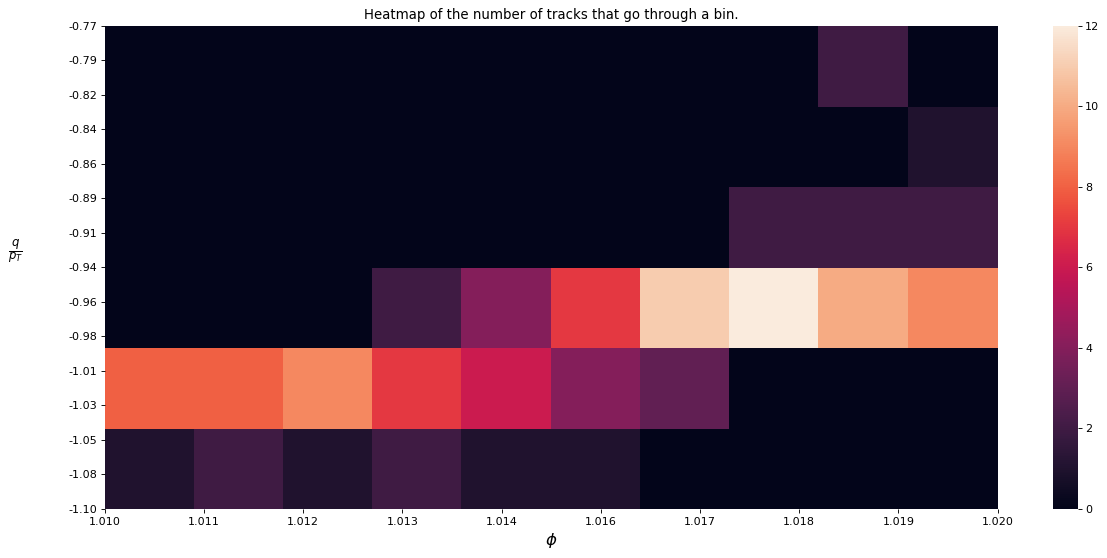

In [12]:
# size
plt.figure(figsize=(18, 8), dpi=80)

# x-axis ticks-labels
plt.locator_params(axis='x', nbins=10)
xticks = np.linspace(0, roi_accumulator.shape[0], 10)
x_range = np.linspace(lower_phi, upper_phi, xticks.shape[0])
xtick_labels = ['{:.3f}'.format(tick) for tick in x_range]

# y-axis ticks-labels
plt.locator_params(axis='y', nbins=15)
yticks = np.linspace(0, roi_accumulator.shape[1], 15)
y_range = np.linspace(lower_qpt, upper_qpt, yticks.shape[0])
ytick_labels = ['{:.2f}'.format(tick) for tick in y_range]

# heatmap
ax = sns.heatmap(roi_accumulator.T)

# config
ax.set_xlabel('$\phi$', fontsize=15)
h = ax.set_ylabel('$\\frac{q}{p_T}$', fontsize=15)
h.set_rotation(0)

ax.yaxis.set_label_coords(-0.1, 0.50)
ax.invert_yaxis()

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=0)

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, rotation=0)

ax.set_title('Heatmap of the number of tracks that go through a bin.')

plt.show()

Let's cross check that the emittance angle $\phi_0$ falls in the right bin.

In [13]:
phi_est = list(est_tracks_to_hits.keys())[0][0]
phi_truth = np.arctan2(initial_df['py'], initial_df['px']).item()
print(f'Estimated phi:\t{phi_est:.3f}\nTruth phi:\t{phi_truth:.3f}')

Estimated phi:	1.016
Truth phi:	1.016


## Now let's try to detect the helical trajectory (for the x-y plane) in a multi-particle file

In [14]:
# root_dir = os.path.join('..', '..', '..', 'data', 'pdg13-n25-0.5to10GeV-0.5eta')
root_dir = os.path.join('..', '..', '..', 'data', 'pdg13-n25-69GeV-0.5eta')

hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
final_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_final.csv")])

dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
       for file in hit_files]
initial_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
               for file in initial_files]
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]

In [15]:
random.seed(2021)
random_event = random.choice(range(0, len(dfs)))
print(f'Event chosen: {hit_files[random_event]}')
df = dfs[random_event]
initial_df = initial_dfs[random_event]
final_df = final_dfs[random_event]
df['weight'] = 1.0
df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
df['phi'] = np.arctan2(df['ty'], df['tx'])
df['track'] = df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
df.head()

Event chosen: event000000051-hits.csv


,particle_id,geometry_id,tx,ty,tz,tt,tpx,tpy,tpz,te,deltapx,deltapy,deltapz,deltae,index,weight,r,phi,track
0,4503599677702144,1224979236083728395,31.322277,7.171088,-12.529307,0.115043,67.257622,15.408198,-26.904760,74.059959,0,0,0,0,0,1.0,32.132687,0.225066,"(32.13268650617254, 0.22506643617439298)"
1,4503599879028736,1224979236083728396,32.101795,0.706315,9.383320,0.111586,68.983093,1.527420,20.163744,71.885933,0,0,0,0,0,1.0,32.109565,0.021999,"(32.109564565545774, 0.021998816887113616)"
2,4503599677702144,1224979236083728409,32.483971,7.437230,-12.994016,0.119310,67.257462,15.408895,-26.904760,74.059959,0,0,0,0,1,1.0,33.324476,0.225072,"(33.324476447665525, 0.22507163227568647)"
3,4503599744811008,1224979236083728409,29.819157,12.171247,-13.163866,0.116060,63.879715,26.084133,-28.201738,74.540924,0,0,0,0,0,1.0,32.207474,0.387528,"(32.2074737606286, 0.3875284964236143)"
4,4503599862251520,1224979236083728423,-26.496473,-19.826971,-7.394898,0.113110,-55.239445,-41.347359,-15.418429,70.701759,0,0,0,0,1,1.0,33.093381,-2.499189,"(33.0933812164585, -2.4991886556370737)"


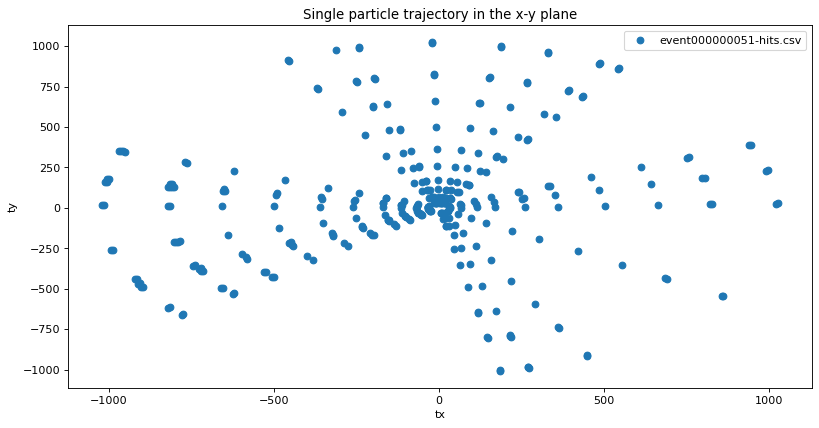

In [16]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=df['tx'], y=df['ty'], label=hit_files[random_event])

plt.xlabel('tx')
plt.ylabel('ty')
plt.legend(loc='best')
plt.title('Single particle trajectory in the x-y plane')
plt.show()

In [17]:
all_tracks = list(df['track'])

Let's define here the bin size and the range of search in the x-axis ($\phi_0$).

In [18]:
bin_size = (0.005, 0.05)
width_limits = (0, np.pi)
x_range = np.arange(width_limits[0], width_limits[1], bin_size[0])

Let's plot the tracks in the Hough Space.

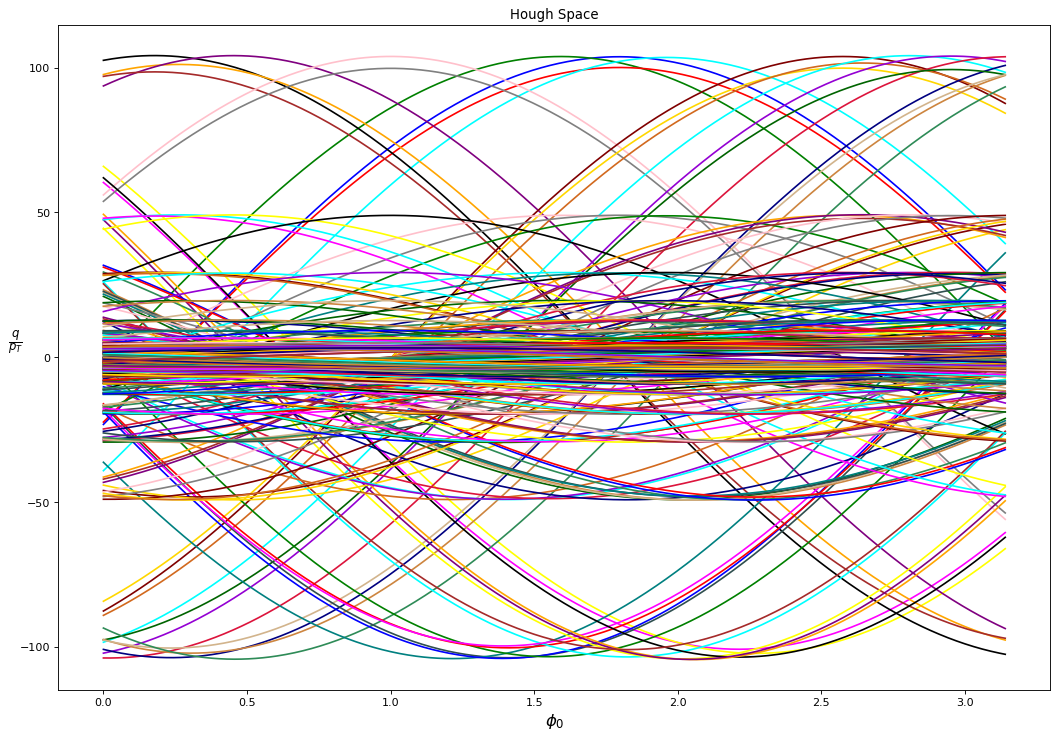

In [19]:
min_y, max_y = float('inf'), float('-inf')

plt.figure(figsize=(16, 11), dpi=80)
for idx, track in enumerate(all_tracks):
    r, phi = track
    label = '$\sin$($x$ - ' + '{:.3f}'.format(phi) + ') / ($3*10^{-4}$' + '{:.3f}'.format(r) + ')'
    ys = np.sin(x_range - phi) / (A * r) if use_sin else (x_range - phi) / (A * r)
    min_y = min(np.min(ys), min_y)
    max_y = max(np.max(ys), max_y)
    plt.plot(x_range, ys, color=colors[idx % len(colors)])

plt.xlabel('$\phi_0$', fontsize=15)
h = plt.ylabel('$\\frac{q}{p_T}$', fontsize=15)
h.set_rotation(0)
plt.title('Hough Space')
plt.show()

Let's run the pipeline and plot the results.

In [20]:
from notebook_utils import pipeline

height_limits = (min_y - 1, max_y + 1)
limits = (width_limits, height_limits)
selection_hyperparams = {'minimum-hits-per-bin': 10}

accumulator, est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, selection_hyperparams, use_sin=use_sin)
len(est_tracks_to_hits)

19

In [21]:
lower_qpt = -8
upper_qpt = 6

low_qpt_bin = int((lower_qpt - height_limits[0] - 1e-12) / bin_size[1])
high_qpt_bin = int((upper_qpt - height_limits[0] - 1e-12) / bin_size[1])

roi_accumulator = accumulator[:, low_qpt_bin:high_qpt_bin]

low_qpt_bin, high_qpt_bin

(1945, 2225)

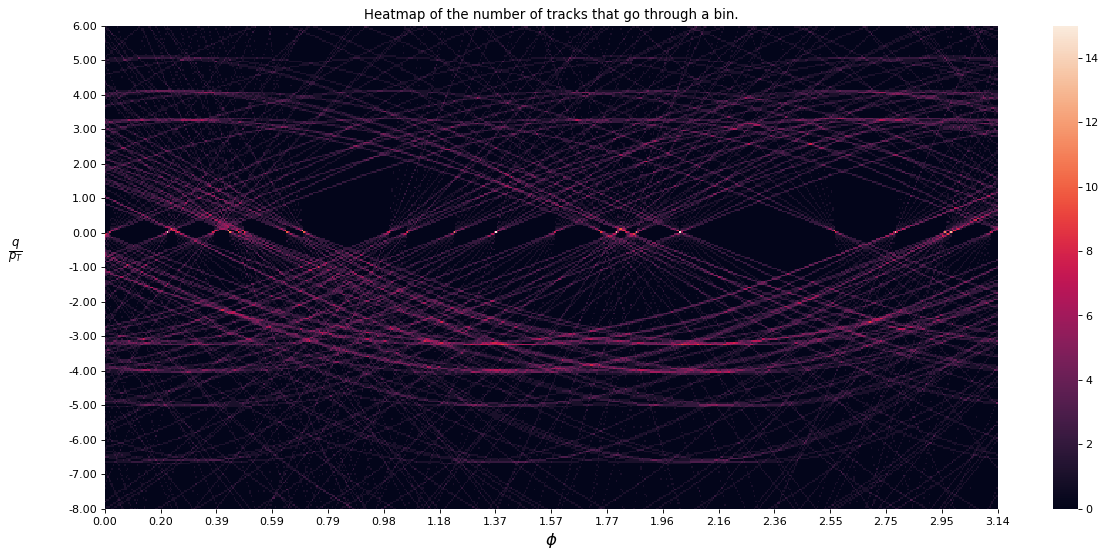

In [22]:
# size
plt.figure(figsize=(18, 8), dpi=80)

# x-axis ticks-labels
plt.locator_params(axis='x', nbins=17)
xticks = np.linspace(0, roi_accumulator.shape[0], 17)
x_range = np.linspace(width_limits[0], width_limits[1], xticks.shape[0])
xtick_labels = ['{:.2f}'.format(tick) for tick in x_range]

# y-axis ticks-labels
plt.locator_params(axis='y', nbins=15)
yticks = np.linspace(0, roi_accumulator.shape[1], 15)
y_range = np.linspace(lower_qpt, upper_qpt, yticks.shape[0])
ytick_labels = ['{:.2f}'.format(tick) for tick in y_range]

# heatmap
ax = sns.heatmap(roi_accumulator.T)

# config
ax.set_xlabel('$\phi$', fontsize=15)
h = ax.set_ylabel('$\\frac{q}{p_T}$', fontsize=15)
h.set_rotation(0)

ax.yaxis.set_label_coords(-0.1, 0.50)
ax.invert_yaxis()

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=0)

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, rotation=0)

ax.set_title('Heatmap of the number of tracks that go through a bin.')

plt.show()

## Now let's calculate the efficiency for different $p_T$ values

First we need to define a custom efficiency function that will return the reconstructed particles along with the actual efficiency rate.

In [23]:
from metrics import get_track_to_truth_row_mapping, matching_probability

def custom_efficiency_rate(hits_per_estimated_track, truth_df, threshold=0.5):
    """ Custom efficiency rate function. The difference is that it also returns the reconstructed particles. """
    num_true_particles = len(set(truth_df['particle_id']))
    track_to_truth_df_row = get_track_to_truth_row_mapping(truth_df)
    found_particles = set()
    for hits in hits_per_estimated_track:
        pid, prob = matching_probability(hits, track_to_truth_df_row, truth_df)
        if prob >= threshold:
            found_particles.add(pid)
        if len(found_particles) == num_true_particles:
            break

    return found_particles, len(found_particles) / len(set(truth_df['particle_id']))

Let's now find the min-maz values of $p_T$ and then define the range of search for it.

In [24]:
initial_df['pt'] = np.sqrt(initial_df['px'] ** 2 + initial_df['py'] ** 2)
pt_min, pt_max = min(set(initial_df['pt'])), max(set(initial_df['pt']))
print(f'Min p_T = {pt_min},\tMax p_T = {pt_max}')

Min p_T = 68.99998976110965,	Max p_T = 69.00001101928355


In [25]:
from notebook_utils import get_str

number_of_bins = 10
bin_length = (pt_max - pt_min) / number_of_bins

pts_range = np.arange(pt_min, pt_max + 1e-8, bin_length)
# pt_keys = ['0.49 – 1.42', '1.43 – 2.35', ...]
pt_keys = ['{} – {}'.format(get_str(pts_range[i]), get_str(pts_range[i+1]))
           for i in range(0, len(pts_range) - 1)]

pt_range_counts = {pt_range: 0 for pt_range in pt_keys}
for pt in list(initial_df['pt']):
    _bin = int((pt - pt_min - 1e-12) / bin_length)
    pt_range_counts[pt_keys[_bin]] += 1
count_max = max(pt_range_counts.values())
pt_range_counts

{'68.99 – 68.99': 11, '68.99 – 69.0': 6, '69.0 – 69.0': 8}

### Let's now define the common hyperparameters and compute the transformations (with/without $\sin()$) to compare the plots.

In [26]:
all_tracks = list(df['track'])
bin_size = (0.01, 0.1)
width_limits = (0, np.pi)
height_limits = (-500, 1000)
limits = (width_limits, height_limits)

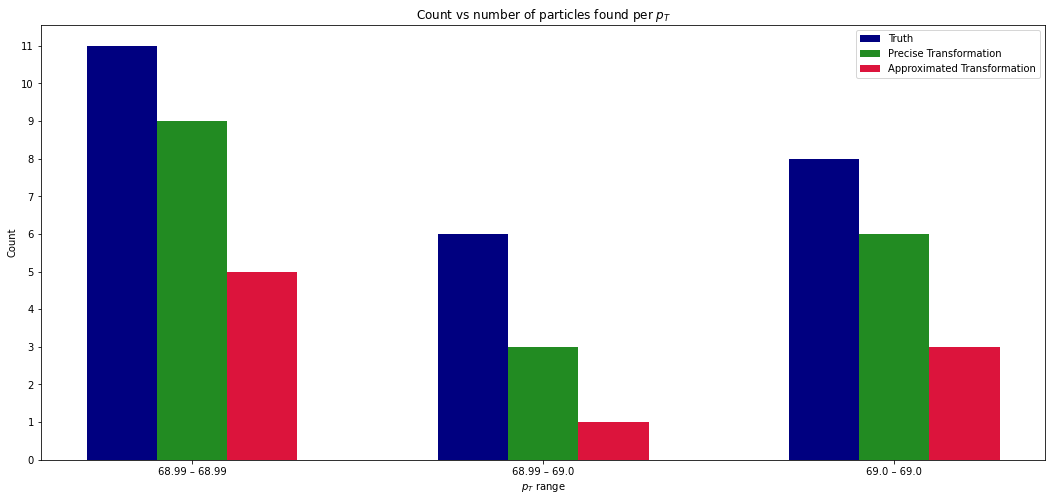

In [27]:
# get estimated tracks and reco particles for sin() transofrmation
_, est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, {'minimum-hits-per-bin': 10}, use_sin=True)
pids_found, _ = custom_efficiency_rate(est_tracks_to_hits.values(), df)
# compute the counts
sin_est_pt_range_counts = {pt_range: 0 for pt_range in pt_keys}
for pid in pids_found:
    pt = initial_df[initial_df['particle_id'] == pid]['pt'].item()
    _bin = int((pt - pt_min - 1e-12) / bin_length)
    sin_est_pt_range_counts[pt_keys[_bin]] += 1
    
# get estimated tracks and reco particles without sin() transofrmation
_, est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, {'minimum-hits-per-bin': 10}, use_sin=False)
pids_found, _ = custom_efficiency_rate(est_tracks_to_hits.values(), df)
# compute the counts
no_sin_est_pt_range_counts = {pt_range: 0 for pt_range in pt_keys}
for pid in pids_found:
    pt = initial_df[initial_df['particle_id'] == pid]['pt'].item()
    _bin = int((pt - pt_min - 1e-12) / bin_length)
    no_sin_est_pt_range_counts[pt_keys[_bin]] += 1

    
# plot the results
fig, ax = plt.subplots(figsize=(18, 8))

xticks_r = np.arange(0, len(pt_range_counts.keys()))
bar_width = 0.2

ax.bar(xticks_r - bar_width, list(pt_range_counts.values()), color='navy', label='Truth',
       width=bar_width)
ax.bar(xticks_r, list(sin_est_pt_range_counts.values()), color='forestgreen',
       label='Precise Transformation', width=bar_width)
ax.bar(xticks_r + bar_width, list(no_sin_est_pt_range_counts.values()), color='crimson',
       label='Approximated Transformation', width=bar_width)

ax.set_xlabel('$p_T$ range')
ax.set_xticks(xticks_r)
ax.set_xticklabels(list(pt_range_counts.keys()))
ax.set_ylabel('Count')
ax.set_yticks(np.arange(0, count_max + 1))
ax.set_title('Count vs number of particles found per $p_T$')
ax.legend()

plt.show()

The results, are as expected: slightly better for the precise transformation. Though, we have the problem of not enough data to say that these results generalize. We will do this again, this time for the whole dataset (and also for $\eta$).

In [28]:
pts = []
etas = []

for df, initial_df in zip(dfs, initial_dfs):
    
    df['weight'] = 1.0
    df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
    df['phi'] = np.arctan2(df['ty'], df['tx'])
    df['track'] = df[['r', 'phi']].apply(lambda pair: (pair[0], pair[1]), 1)

    initial_df['pt'] = np.sqrt(initial_df['px'] ** 2 + initial_df['py'] ** 2)
    initial_df['|p|'] = np.sqrt(initial_df['px'] ** 2 + initial_df['py'] ** 2 + initial_df['pz'] ** 2)
    initial_df['theta'] = np.arccos(initial_df['pz'] / initial_df['|p|'])
    initial_df['eta'] = -np.log(np.tan(initial_df['theta'] / 2))
    
    for pt, eta in zip(initial_df['pt'], initial_df['eta']):
        pts.append(pt)
        etas.append(eta)

pts = list(set(pts))
etas = list(set(etas))

pt_min = min(pts)
pt_max = max(pts)
print(f'Min p_T = {pt_min},\tMax p_T = {pt_max}')

eta_min = min(etas)
eta_max = max(etas)
print(f'Min eta = {eta_min},\tMax eta = {eta_max}')

Min p_T = 68.99998852857043,	Max p_T = 69.00001141202733
Min eta = -0.49921990838498503,	Max eta = 0.4994593631832546


Define the ranges of search and the dictionaries that will store the counts for each group.

In [29]:
pt_number_of_bins = 10
pt_bin_length = (pt_max - pt_min) / pt_number_of_bins

eta_number_of_bins = 10
eta_bin_length = (eta_max - eta_min) / eta_number_of_bins

pts_range = np.arange(pt_min, pt_max + 1e-8, pt_bin_length)
pt_keys = ['{} – {}'.format(get_str(pts_range[i]), get_str(pts_range[i+1]))
           for i in range(0, len(pts_range) - 1)]

etas_range = np.arange(eta_min, eta_max + 1e-8, eta_bin_length)
eta_keys = ['{} – {}'.format(get_str(etas_range[i]), get_str(etas_range[i+1]))
            for i in range(0, len(etas_range) - 1)]

In [30]:
# count particles found
pt_counts = {pt_range: 0 for pt_range in pt_keys}
eta_counts = {eta_range: 0 for eta_range in eta_keys}

precise_pt_counts = {pt_range: 0 for pt_range in pt_keys}
precise_eta_counts = {eta_range: 0 for eta_range in eta_keys}

approx_pt_counts = {pt_range: 0 for pt_range in pt_keys}
approx_eta_counts = {eta_range: 0 for eta_range in eta_keys}

Let's define the hyperparameters.

In [31]:
bin_size = (0.01, 0.1)
width_limits = (0, np.pi)
height_limits = (-500, 1000)
limits = (width_limits, height_limits)
hyperparams = {'minimum-hits-per-bin': 10}

Apply Hough transformation for every event (essentially the whole dataset) and keep track of the results.

In [32]:
desc = 'Applying Hough Transform to whole Dataset'
for df, initial_df in tqdm(zip(dfs, initial_dfs), total=len(dfs), desc=desc):

    # let's compute the ground truth counts
    for pt, eta in zip(list(initial_df['pt']), list(initial_df['eta'])):

        pt_bin = int((pt - pt_min - 1e-12) / pt_bin_length)
        eta_bin = int((eta - eta_min - 1e-12) / eta_bin_length)

        pt_counts[pt_keys[pt_bin]] += 1
        eta_counts[eta_keys[eta_bin]] += 1

    # get all the tracks
    all_tracks = list(df['track'])

    # get estimated tracks and reco particles for the precise transformation
    _, est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, hyperparams, use_sin=True)
    pids_found, _ = custom_efficiency_rate(est_tracks_to_hits.values(), df)

    # compute the counts
    for pid in pids_found:
        pt = initial_df[initial_df['particle_id'] == pid]['pt'].item()
        eta = initial_df[initial_df['particle_id'] == pid]['eta'].item()

        pt_bin = int((pt - pt_min - 1e-12) / pt_bin_length)
        eta_bin = int((eta - eta_min - 1e-12) / eta_bin_length)

        precise_pt_counts[pt_keys[pt_bin]] += 1
        precise_eta_counts[eta_keys[eta_bin]] += 1

    # get estimated tracks and reco particles for the approximated transofrmation
    _, est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, hyperparams, use_sin=False)
    pids_found, _ = custom_efficiency_rate(est_tracks_to_hits.values(), df)

    # compute the counts
    for pid in pids_found:
        pt = initial_df[initial_df['particle_id'] == pid]['pt'].item()
        eta = initial_df[initial_df['particle_id'] == pid]['eta'].item()

        pt_bin = int((pt - pt_min - 1e-12) / pt_bin_length)
        eta_bin = int((eta - eta_min - 1e-12) / eta_bin_length)

        approx_pt_counts[pt_keys[pt_bin]] += 1
        approx_eta_counts[eta_keys[eta_bin]] += 1

Applying Hough Transform to whole Dataset:   0%|          | 0/100 [00:00<?, ?it/s]

Now let's do the plots.

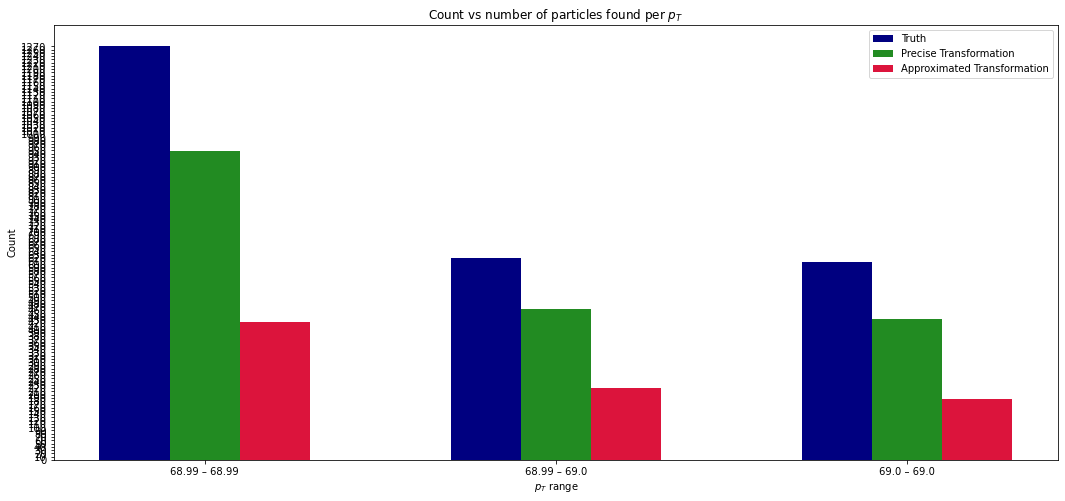

In [33]:
# plot count vs p_T
fig, ax = plt.subplots(figsize=(18, 8))

xticks_r = np.arange(0, len(pt_counts.keys()))
count_max = max(pt_counts.values())
bar_width = 0.2

ax.bar(xticks_r - bar_width, list(pt_counts.values()), color='navy', label='Truth',
       width=bar_width)
ax.bar(xticks_r, list(precise_pt_counts.values()), color='forestgreen',
       label='Precise Transformation', width=bar_width)
ax.bar(xticks_r + bar_width, list(approx_pt_counts.values()), color='crimson',
       label='Approximated Transformation', width=bar_width)

ax.set_xlabel('$p_T$ range')
ax.set_xticks(xticks_r)
ax.set_xticklabels(list(pt_counts.keys()))
ax.set_ylabel('Count')
ax.set_yticks(np.arange(0, count_max + 1, 10))
ax.set_title('Count vs number of particles found per $p_T$')
ax.legend()

plt.show()

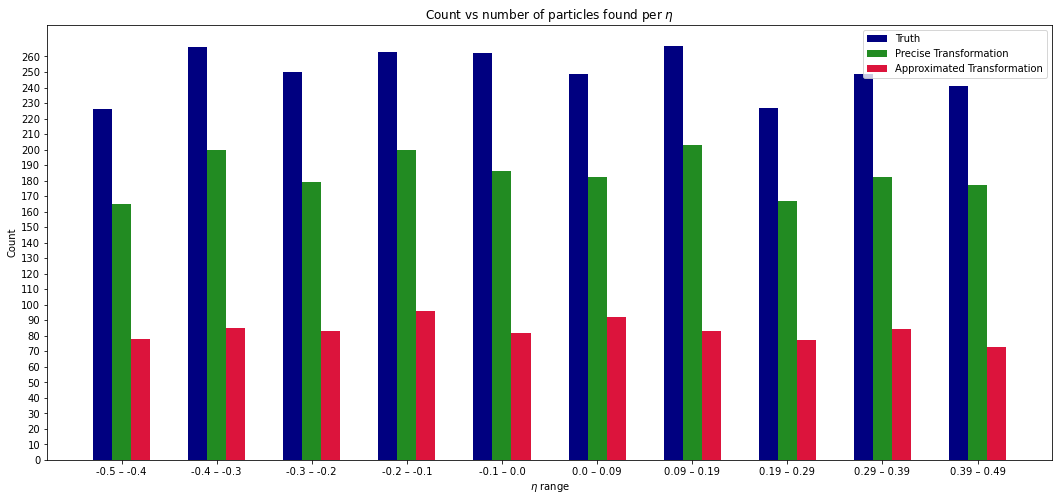

In [34]:
# plot count vs eta
fig, ax = plt.subplots(figsize=(18, 8))

xticks_r = np.arange(0, len(eta_counts.keys()))
count_max = max(eta_counts.values())
bar_width = 0.2

ax.bar(xticks_r - bar_width, list(eta_counts.values()), color='navy', label='Truth',
       width=bar_width)
ax.bar(xticks_r, list(precise_eta_counts.values()), color='forestgreen',
       label='Precise Transformation', width=bar_width)
ax.bar(xticks_r + bar_width, list(approx_eta_counts.values()), color='crimson',
       label='Approximated Transformation', width=bar_width)

ax.set_xlabel('$\eta$ range')
ax.set_xticks(xticks_r)
ax.set_xticklabels(list(eta_counts.keys()))
ax.set_ylabel('Count')
ax.set_yticks(np.arange(0, count_max + 1, 10))
ax.set_title('Count vs number of particles found per $\eta$')
ax.legend()

plt.show()

Let's plot now the efficiencies.

In [35]:
pt_precise_eff = {pt_range: precise_pt_counts[pt_range] / pt_counts[pt_range] for pt_range in pt_keys}
pt_approx_eff = {pt_range: approx_pt_counts[pt_range] / pt_counts[pt_range] for pt_range in pt_keys}

eta_precise_eff = {eta_range: precise_eta_counts[eta_range] / eta_counts[eta_range] for eta_range in eta_keys}
eta_approx_eff = {eta_range: approx_eta_counts[eta_range] / eta_counts[eta_range] for eta_range in eta_keys}

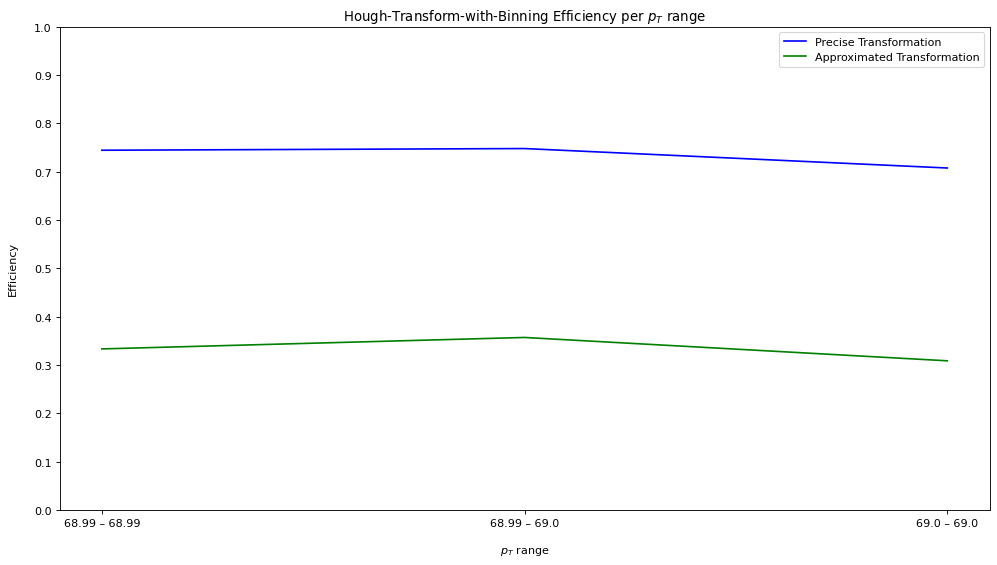

In [36]:
plt.figure(figsize=(15, 8), dpi=80)

plt.plot(list(pt_precise_eff.keys()), list(pt_precise_eff.values()), color='blue', label='Precise Transformation')
plt.plot(list(pt_approx_eff.keys()), list(pt_approx_eff.values()), color='green', label='Approximated Transformation')

plt.xlabel('\n$p_T$ range')
plt.ylabel('Efficiency\n')
plt.yticks(np.arange(0, 1.01, step=0.1))

plt.title('Hough-Transform-with-Binning Efficiency per $p_T$ range')
plt.legend()
plt.show()

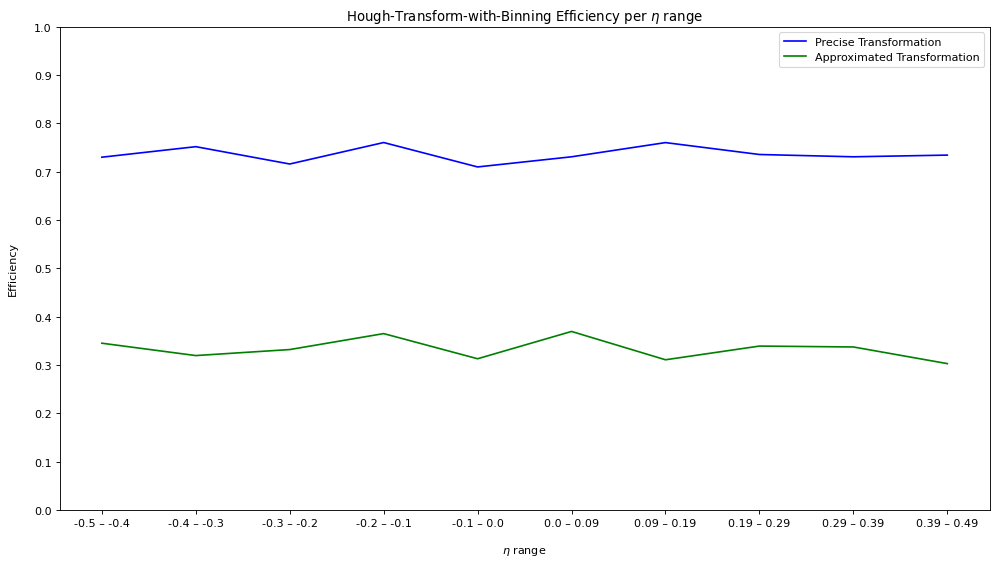

In [37]:
plt.figure(figsize=(15, 8), dpi=80)

plt.plot(list(eta_precise_eff.keys()), list(eta_precise_eff.values()), color='blue', label='Precise Transformation')
plt.plot(list(eta_approx_eff.keys()), list(eta_approx_eff.values()), color='green', label='Approximated Transformation')

plt.xlabel('\n$\eta$ range')
plt.ylabel('Efficiency\n')
plt.yticks(np.arange(0, 1.01, step=0.1))

plt.title('Hough-Transform-with-Binning Efficiency per $\eta$ range')
plt.legend()
plt.show()

## Now let's do this again for all $p_T$ values grouped together in discrete dataframes

First we need to group together the tracks with similar eta values. Therefore, we have to calculate the $p_T$ values.

In [38]:
# p_ts = []

# for df, initial_df in zip(dfs, initial_dfs):
    
#     df['weight'] = 1.0
#     df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
#     df['phi'] = np.arctan2(df['ty'], df['tx'])
#     df['track'] = df[['r', 'phi']].apply(lambda pair: (pair[0], pair[1]), 1)

#     initial_df['pt'] = np.sqrt(initial_df['px'] ** 2 + initial_df['py'] ** 2)
    
#     for p_t in initial_df['pt']:
#         p_ts.append(p_t)

# p_ts = list(set(p_ts))

# min_p_t = min(p_ts)
# max_p_t = max(p_ts)
# print(f'Min p_T = {min_p_t},\tMax p_T = {max_p_t}')

Separate the tracks with similar $p_T$ values in dataframes.

In [39]:
# from notebook_utils import get_str

# number_of_bins = 10
# bin_length = (max_p_t - min_p_t) / number_of_bins

# p_ts_range = np.arange(min_p_t, max_p_t + 1e-8, bin_length)
# p_t_keys = ['{} – {}'.format(get_str(p_ts_range[i]), get_str(p_ts_range[i+1]))
#             for i in range(0, len(p_ts_range) - 1)]

# df_per_p_t = [pd.DataFrame(columns=dfs[0].columns) for _ in range(number_of_bins)]
# tracks_per_bin = np.zeros(number_of_bins)

# # iterate through all the dataframes and start placing each particle track in the corresponding p_T dataframe
# for idx, (df, initial_df) in enumerate(zip(dfs, initial_dfs)):
#     _df = df.copy()
#     unique_particles = set(_df['particle_id'])
#     _df['particle_id'] = _df['particle_id'] + '_{}'.format(idx)

#     for pid in unique_particles:
#         particle_df = _df[_df['particle_id'] == pid + '_{}'.format(idx)]
#         p_t = initial_df.loc[initial_df['particle_id'] == pid, 'pt'].item()
#         _bin = int((p_t - min_p_t - 1e-12) / bin_length)

#         df_per_p_t[_bin] = pd.concat([df_per_p_t[_bin], particle_df], sort=False)
#         tracks_per_bin[_bin] += 1

# # reset the indices
# for _bin in range(number_of_bins):
#     df_per_p_t[_bin] = df_per_p_t[_bin].reset_index().drop(['level_0'], axis=1)

### Let's now define the common hyperparameters and compute the transformations (with/without $\sin()$) to compare the plots.

In [40]:
# bin_size = (0.0085, 0.1)
# width_limits = (0, np.pi)
# height_limits = (-500, 1000)
# limits = (width_limits, height_limits)

In [41]:
# # compute the actual count of unique particles per bin
# count_pids_per_p_t = {}
# for _bin in range(number_of_bins):
#     df = df_per_p_t[_bin]
#     count_pids_per_p_t[p_t_keys[_bin]] = len(set(df['particle_id']))
# count_max = max(count_pids_per_p_t.values())


# # compute efficiency for all the precise transformation over all the dataset
# sin_eff_per_p_t = {}
# sin_pids_found_pet_p_t = {}
# for _bin in range(number_of_bins):
#     start_time = time.time()
    
#     df = df_per_p_t[_bin]
#     all_tracks = list(df['track'])
#     _, est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, {'minimum-hits-per-bin': 12}, use_sin=True)
    
#     pids_found, eff = custom_efficiency_rate(est_tracks_to_hits.values(), df)
#     sin_pids_found_pet_p_t[p_t_keys[_bin]] = len(pids_found)
#     sin_eff_per_p_t[p_t_keys[_bin]] = eff
    
#     et = time.time() - start_time
#     print(f'Finished bin {_bin} after {et:.2f} seconds,  with efficiency: {sin_eff_per_p_t[p_t_keys[_bin]]}!')
# print()
    
    
# # compute efficiency for all the approximated transformation over all the dataset
# line_eff_per_p_t = {}
# line_pids_found_pet_p_t = {}
# for _bin in range(number_of_bins):
#     start_time = time.time()

#     df = df_per_p_t[_bin]
#     all_tracks = list(df['track'])
#     _, est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, {'minimum-hits-per-bin': 12}, use_sin=False)

#     pids_found, eff = custom_efficiency_rate(est_tracks_to_hits.values(), df)
#     line_pids_found_pet_p_t[p_t_keys[_bin]] = len(pids_found)
#     line_eff_per_p_t[p_t_keys[_bin]] = eff

#     et = time.time() - start_time
#     print(f'Finished bin {_bin} after {et:.2f} seconds,  with efficiency: {line_eff_per_p_t[p_t_keys[_bin]]}!')

### Let's plot the results

In [42]:
# # now plot the counts
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), dpi=80)
# fig.subplots_adjust(bottom = -0.45)

# # Number of generated particles vs generated $p_T$
# ax1.bar(list(count_pids_per_p_t.keys()), list(count_pids_per_p_t.values()), color='deepskyblue')
# ax1.set_xlabel('$p_T$ range')
# ax1.set_ylabel('Count\n')
# ax1.set_yticks(np.arange(0, count_max + 1, 10))
# ax1.set_title('Number of generated particles vs generated $p_T$')

# # Number of generated found particles vs generated p_T for the precise transformation
# ax2.bar(list(sin_pids_found_pet_p_t.keys()), list(sin_pids_found_pet_p_t.values()), color='deepskyblue')
# ax2.set_xlabel('$p_T$ range')
# ax2.set_ylabel('Count\n')
# ax2.set_yticks(np.arange(0, count_max + 1, 10))
# ax2.set_title('Number of generated found particles vs generated $p_T$ for the precise transformation')

# # Number of generated found particles vs generated p_T for the approximated transformation
# ax3.bar(list(line_pids_found_pet_p_t.keys()), list(line_pids_found_pet_p_t.values()), color='deepskyblue')
# ax3.set_xlabel('$p_T$ range')
# ax3.set_ylabel('Count\n')
# ax3.set_yticks(np.arange(0, count_max + 1, 10))
# ax3.set_title('Number of generated found particles vs generated $p_T$ for the approximated transformation')

# plt.show()

Now let's also plot the efficiencies.

In [43]:
# plt.figure(figsize=(15, 8), dpi=80)

# plt.plot(list(sin_eff_per_p_t.keys()), list(sin_eff_per_p_t.values()), color='blue', label='Precise Transformation')
# plt.plot(list(line_eff_per_p_t.keys()), list(line_eff_per_p_t.values()), color='green', label='Approximated Transformation')

# plt.xlabel('\n$p_T$ range')
# plt.ylabel('Efficiency\n')
# plt.yticks(np.arange(0, 1.01, step=0.1))

# plt.title('Hough-Transform-with-Binning Efficiency per $p_T$ range')
# plt.legend()
# plt.show()